# Preface

In this notebook, we introduce basic linear models for regression and classification. We will use basic functionalities of the machine learning library `scikit-learn`. Install this by
```
$pip install scikit-learn
```
Documentation is found [here](https://scikit-learn.org/stable/).

We will also need `pandas`, `numpy` and plotting libraries `matplotlib` and `seaborn`.
```
$pip install numpy pandas matplotlib seaborn
```

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Singapore Housing Dataset

This dataset is obtained from a [Govtech database](https://data.gov.sg). Read the description in the website for more information. We are going to only use a subset of this data as a simple demonstration.

## Load Data

The data has been downloaded into the repository for convenience. You also also get this (and more) [here](https://data.gov.sg/dataset/resale-flat-prices). We will only use the dataset `resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv` in this simple demo. Besure to place the data in a directory `data/` relative to the directory of this notebook. 

In [ ]:
raw_dataset = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [ ]:
raw_dataset.head()

In [ ]:
raw_dataset.columns

## Preprocess Data

Some data should be numerical but we can't easily work with them, so let's do some preprocessing.

In [ ]:
def convert_to_years(years_and_months):
    """
    Convert n years m months to (n + m/12) years
    
    Also checkout the datetime package for more general usage
    https://docs.python.org/3/library/datetime.html
    """
    split = years_and_months.split(' ')
    if len(split) == 2:
        return float(split[0])
    elif len(split) == 4:
        return float(split[0]) + float(split[2]) / 12.0
    else:
        raise ValueError('Wrong format.')

def average_storey(storey_range):
    """
    Convert n to m to (n+m)/2
    """
    split = storey_range.split(' TO ')
    if len(split) == 2:
        return 0.5 * (float(split[0]) + float(split[1]))
    else:
        raise ValueError('Wrong format.')

dataset = raw_dataset.copy()
dataset['remaining_lease'] = dataset['remaining_lease'].apply(convert_to_years)
dataset['storey'] = dataset['storey_range'].apply(average_storey)

In [ ]:
dataset.head()

## Some Visualizations

We will visualize the data to find some patterns. The `seaborn` plotting library has some useful tools to do this.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

sns.barplot(
    x='resale_price',
    y='town',
    data=dataset,
    orient='h',
    ci='sd',
    ax=ax[0]
)

sns.barplot(
    x='resale_price',
    y='storey',
    data=dataset,
    orient='h',
    ci='sd',
    ax=ax[1]
)

sns.scatterplot(
    x='resale_price',
    y='floor_area_sqm',
    hue='remaining_lease',
    data=dataset,
    ax=ax[2]
)

fig.tight_layout()

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

## Train Test Split

We will know proceed to fit some models to predict the *resale_price* given some input descriptors. This is a classical regression problem. 

To evaluate our machine learning models, we should have at least 1 hold-out test set that is untouched by our learning algorithm, until evaluation time. Since no hyper-parameter tuning is performed, it is sufficient to keep a single test set for this purpose. We use some handy functions from `sklearn`. 

In [11]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1)

In [ ]:
len(dataset), len(dataset_train), len(dataset_test)

In [ ]:
dataset_train.head()

In [ ]:
dataset_test.head()

## Simple Linear Regression

We can see from the visualization that floor area is related to price. Rather, we should know this without seeing any data. We now try to regress the resale price from floor area alone and see how we do. 

Instead of coding our own ordinary least squares solver, `sklearn` (and many other libraries) have ready-made implementations. 

In [ ]:
from sklearn.linear_model import LinearRegression;

In [ ]:
inputs = 'floor_area_sqm'
outputs = 'resale_price'

x_train = dataset_train[inputs][:, np.newaxis]
x_test = dataset_test[inputs][:, np.newaxis]

y_train = dataset_train[outputs]
y_test = dataset_test[outputs]

In [ ]:
dataset_train[inputs][:, np.newaxis]

In [ ]:
regressor = LinearRegression()
regressor.fit(
    X=x_train,
    y=y_train,
)
y_hat_train = regressor.predict(x_train)
y_hat_test = regressor.predict(x_test)

### Visualizing Regression Result

Since we are working in one dimension, it is possible to visualize our linear fit.

Note that the following can be directly reproduced by a single `sns.regplot` call from `seaborn`, without explicitly using `LinearRegression()` from `sklearn`. 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

sns.scatterplot(
    x=x_train.ravel(),
    y=y_train,
    ax=ax[0],
    alpha=0.5,
)
sns.lineplot(
    x=x_train.ravel(),
    y=y_hat_train,
    ax=ax[0],
    color='red',
)

sns.scatterplot(
    x=x_test.ravel(),
    y=y_test,
    ax=ax[1],
    alpha=0.5,
)
sns.lineplot(
    x=x_test.ravel(),
    y=y_hat_test,
    ax=ax[1],
    color='red',
)



for a in ax:
    a.set_xlabel(inputs)
    a.set_ylabel(outputs)

    
ax[0].set_title('Train set')
ax[1].set_title('Test set')




fig.tight_layout()

Alternatively, we can directly compare our predicted resale prices with the ground truth. This works if we have higher dimensional inputs so that a linear fit is difficult to plot graphically.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### Quantifying the Error

Just looking at the fit doesn't tell us very precise information. Therefore, it is often better to quantify the error. One simple metric is the mean-square difference between the predicted outputs and the actual outputs. But this is not the only one! You are encouraged to look at [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) to find more ways to evaluate the results. 

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse_scaled(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    scale = np.sqrt(np.mean(y_true**2))
    return rmse/scale

In [ ]:
print(
    f'Scaled RMSE: \n {rmse_scaled(y_train, y_hat_train)} (Train) \
    \n {rmse_scaled(y_test, y_hat_test)} (Test)'
)

## Polynomial Regression

Simple linear regression gave about 26% error. Can we do better by going to larger hypothesis spaces? Let us now try a **polynomial regression** up to degree 3. This is an example of a linear basis model. 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
phi = PolynomialFeatures(degree=3)
x_poly_train = phi.fit_transform(x_train)
x_poly_test = phi.fit_transform(x_test)

In [ ]:
regressor_poly = LinearRegression()
regressor_poly.fit(
    X=x_poly_train,
    y=y_train,
)
y_hat_poly_train = regressor_poly.predict(x_poly_train)
y_hat_poly_test = regressor_poly.predict(x_poly_test)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

sns.scatterplot(
    x=x_train.ravel(),
    y=y_train,
    ax=ax[0],
    alpha=0.5,
)
sns.lineplot(
    x=x_train.ravel(),
    y=y_hat_poly_train,
    ax=ax[0],
    color='red',
)

sns.scatterplot(
    x=x_test.ravel(),
    y=y_test,
    ax=ax[1],
    alpha=0.5,
)
sns.lineplot(
    x=x_test.ravel(),
    y=y_hat_poly_test,
    ax=ax[1],
    color='red',
)



for a in ax:
    a.set_xlabel(inputs)
    a.set_ylabel(outputs)

    
ax[0].set_title('Train set')
ax[1].set_title('Test set')




fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_poly_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_poly_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

In [ ]:
print(
    f'Scaled RMSE: \n {rmse_scaled(y_train, y_hat_poly_train)} (Train) \
    \n {rmse_scaled(y_test, y_hat_poly_test)} (Test)'
)

Looks like polynomial regression didn't really improve on the simple linear regression result. Why?

## Including More Design Variables in Linear Regression

Clearly, the size of the house is not the only factor determining price. Let us now include some other factors which may contribute. In this case, the regression problem is defined in higher dimenions.

Note that from the viewpoint of approximation, we are also using a bigger **hypothesis space**, but not in the same way as a polynomial basis in one dimension. In the first linear regression example, we are using the hypothesis space consisting of all functions which are affine in *floor_area_sqm* and constant in the other dependent variables. Now, we are using the hypothesis space consisting of affine functions of more than one variable.

In [ ]:
dataset.head()

In [ ]:
inputs = ['town', 'floor_area_sqm', 'remaining_lease', 'storey']
outputs = 'resale_price'

In [ ]:
x_train = dataset_train[dataset_train.columns.intersection(inputs)]
x_train.head()

Note that the "town" column are nominal/categorical variables, so let us perform a **one-hot encoding**. 

In [ ]:
x_train = pd.get_dummies(x_train)
y_train = dataset_train[outputs]
x_train.head()

we repeat this for the test set

In [ ]:
x_test = dataset_test[dataset_test.columns.intersection(inputs)]
x_test = pd.get_dummies(x_test)
y_test = dataset_test[outputs]

now we train the regressor in these new variables

In [ ]:
regressor = LinearRegression()
regressor.fit(
    X=x_train,
    y=y_train,
)
y_hat_train = regressor.predict(x_train)
y_hat_test = regressor.predict(x_test)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

In [ ]:
print(
    f'Scaled RMSE: \n {rmse_scaled(y_train, y_hat_train)} (Train) \
    \n {rmse_scaled(y_test, y_hat_test)} (Test)'
)

Observe from the fit and the RMSE that we are doing quite a bit better than the univariate linear case. Can you improve on this:
  *  Better accuracy?
  *  Smaller number of features?

# Digits Classification

Let us now turn to a simple classification problem and apply linear models. This is a digit recognition problem on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/)

We aim to classify hand-written digits from 0-9 using a linear classifier. Let us first load the dataset and display some images.

In [3]:
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='./data/')
y = y.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


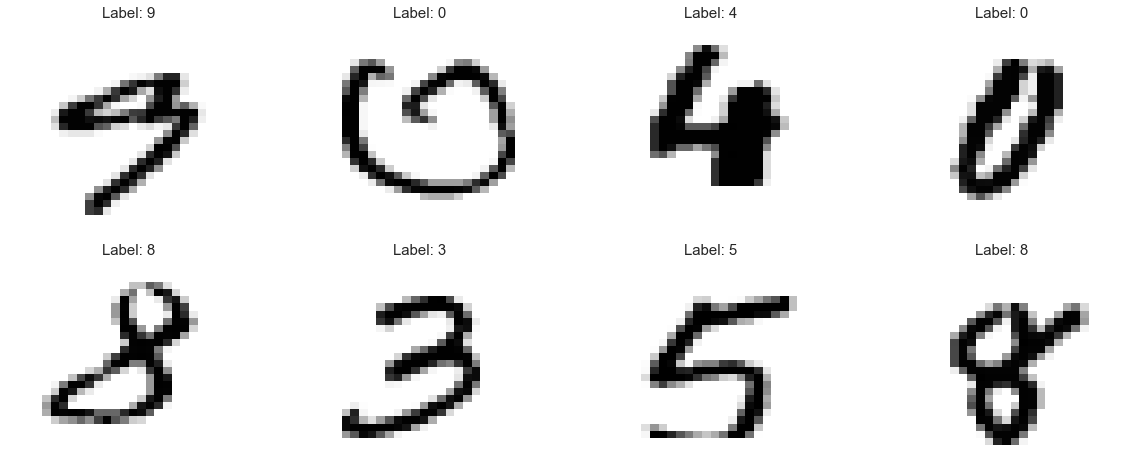

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a in ax.ravel():
    j = np.random.choice(len(y))
    sns.heatmap(x[j].reshape(28,28), ax=a, cbar=False, cmap='gray_r')
    a.set_title(f'Label: {y[j]}')
    a.set_xticks([])
    a.set_yticks([])

## Fit a Linear Classifier

We fit a linear classifier with softmax-crossentropy loss. 

In [6]:
from sklearn.linear_model import LogisticRegression;

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000)
x_train /= 255.0
x_test /= 255.0

In [15]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

We will optimize the linear model using the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) solver. For larger scale problems this is typically inefficient and we will learn more tools based on **stochastic gradient algorithms** later on in the course. We can also ignore the warning of non-convergence since in this task an accurate minimization of the loss function is not necessary to make good predictions on the test set.

In [16]:
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
)

In [17]:
clf.fit(x_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluating our Classifier

How do we evaluate our results? The simplest metric is the accuracy.

In [19]:
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)

print(
    f'Train Accuracy: {(y_hat_train == y_train).mean()} \
    \n Test Accuracy: {(y_hat_test == y_test).mean()}'
)

Train Accuracy: 0.9350833333333334     
 Test Accuracy: 0.9276


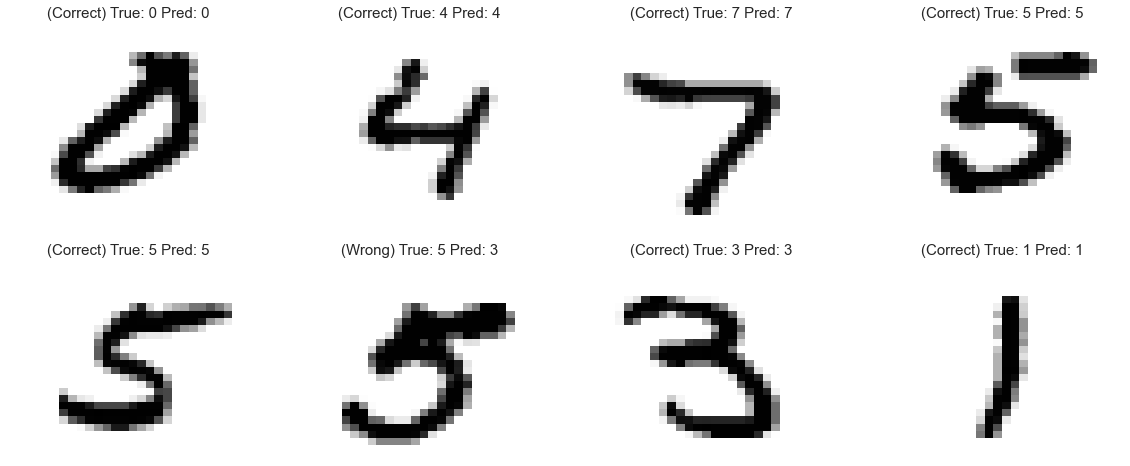

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
result_dict = {True: '(Correct)', False: '(Wrong)'}
for a in ax.ravel():
    j = np.random.choice(len(y_test))
    sns.heatmap(x_test[j].reshape(28,28), ax=a, cbar=False, cmap='gray_r')
    result = y_test[j] == y_hat_test[j]
    a.set_title(f'{result_dict[result]} True: {y_test[j]} Pred: {y_hat_test[j]}')
    a.set_xticks([])
    a.set_yticks([])

What did we tend to get wrong? Another useful checking tool is the **confusion matrix** $M$. Each row of $M$ is the predicted class and each column of $M$ is the actual class. Therefore
$$
    M_{ij} = \text{Number of samples with class } j \text{ that is predicted to be class } i
$$
A larger number of confusions between two classes signify typically that the ML algorithm to separate them needs to be improved.

In [22]:
from sklearn.metrics import confusion_matrix

[[ 932    0    4    2    2    4    5    5    8    2]
 [   0 1113    2    5    2    2    1    1   10    1]
 [   5   18  923   19   15    6    8   17   27    3]
 [   2    5   21  862    0   33    3    7   20    7]
 [   2    3    3    3  922    1   11    4    5   27]
 [  11    3    7   39   11  811   11    7   21    9]
 [   6    4    3    3    4   11  935    1    2    0]
 [   1    3    9    6    7    3    1  983    3   19]
 [   1   17   10   24    3   29   10    1  870   13]
 [   5    2    1   19   18    4    0   25    6  925]]


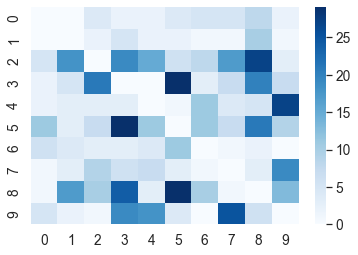

In [23]:
M = confusion_matrix(y_test, y_hat_test)
print(M)
sns.heatmap(M - np.diag(np.diag(M)), robust=True, cmap=plt.cm.Blues);  # We will remove the diagonal for clearer view